In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stable-diffusion-image-to-prompts/sample_submission.csv
/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv
/kaggle/input/stable-diffusion-image-to-prompts/images/f27825b2c.png
/kaggle/input/stable-diffusion-image-to-prompts/images/92e911621.png
/kaggle/input/stable-diffusion-image-to-prompts/images/a4e1c55a9.png
/kaggle/input/stable-diffusion-image-to-prompts/images/20057f34d.png
/kaggle/input/stable-diffusion-image-to-prompts/images/d8edf2e40.png
/kaggle/input/stable-diffusion-image-to-prompts/images/227ef0887.png
/kaggle/input/stable-diffusion-image-to-prompts/images/c98f79f71.png


In [13]:
!pip install jax[cpu]==0.3.25 -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html


In [14]:
!pip install flax transformers torch

In [48]:
import flax,jax
import numpy as onp
import jax.numpy as np
import flax.linen as nn
from transformers import FlaxCLIPVisionModel,CLIPImageProcessor
from PIL import Image
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

(1, 3, 224, 224)


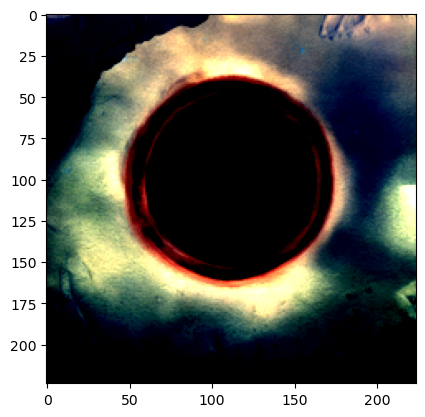

In [20]:
df_train = pd.read_csv("/kaggle/input/stable-diffusion-image-to-prompts/prompts.csv")
image_paths = "/kaggle/input/stable-diffusion-image-to-prompts/images/"+df_train["imgId"]+".png"
prompts = df_train["prompt"]
images=[]
for path in image_paths:
    images.append(onp.asarray(Image.open(path).convert('RGB')))
images=onp.array(images)
preprocessed=processor(images=images[0],return_tensors="np")["pixel_values"]
print(preprocessed.shape)
plt.imshow(preprocessed[0].transpose(1,2,0))

In [41]:
name="openai/clip-vit-base-patch32"
processor = CLIPImageProcessor.from_pretrained(name)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [40]:
class Image2Text(nn.Module):
    def setup(self):
        #image encoder
        name="openai/clip-vit-base-patch32"
        self.encoder = FlaxCLIPVisionModel.from_pretrained(name)
        #text decoder
        self.decoder = AutoModelForMaskedLM.from_pretrained("roberta-base").roberta.encoder
    def __call__(self,x):
        y = self.encoder(x).last_hidden_state #batch,50,768
        y = self.decoder(y)# up to 50 tokens
        return y

In [49]:
# WIP
class Mydatasets(Dataset):
    def __init__(self, data):
        super().__init__()
        self.input_ids=data["input_ids"]
        self.label=data["label"]

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        input_data = self.input_ids[idx]
        labels = self.label[idx]
        return {"inputs":input_data, "labels":labels}
    def __len__(self):
        return len(self.label)
    
class Datacollator:
    def __init__(self,tokenizer,return_tensors="np",basesize=16):
        self.tokenizer=tokenizer
        self.return_tensors=return_tensors
        self.basesize=basesize
    def __call__(self,batch):
        maxlen = max([len(x["input_ids"]) for x in batch])
        pad_to=self.basesize
        while(pad_to<maxlen):
            pad_to=2*pad_to
        padded_data=tokenizer.pad(batch,pad_to_multiple_of=pad_to,return_tensors=self.return_tensors)
        return padded_data